In [79]:
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

## Eigenface

In [156]:
# Read images

IMAGE_DIR = Path('dataset/neutral/')

def load_images(image_dir=''):
    
    train_imgs, test_imgs = list(), list()
    
    train_files = os.listdir(image_dir / 'train')
    test_files = os.listdir(image_dir / 'test')
    
    for file in train_files:
        img = cv2.imread(str(image_dir / 'train' / file))
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        train_imgs.append(img_gray)
        
    for file in test_files:
        img = cv2.imread(str(image_dir / 'test' / file))
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        test_imgs.append(img_gray)

    return train_imgs, test_imgs

train_imgs, test_imgs = load_images(IMAGE_DIR)

In [81]:
# Flatten images

N1, N2 = train_imgs[1].shape

train_flattened = [
    img.reshape(-1, 1) for img in train_imgs
]

test_flattened = [
    img.reshape(-1, 1) for img in test_imgs
]

In [242]:
def get_eigen_values(train_flattened):
    
    # Calculate covariance matrix
    A = np.concatenate(train_flattened, axis=1)
    m = A.mean(axis=1).reshape(-1, 1)
    A = A - m
    X = A.T @ A

    # Eigen value decomposition
    L, V = np.linalg.eig(X)
    U = A @ V
    U = U / np.linalg.norm(U, axis=0)

    return U, m

U, m = get_eigen_values(train_flattened)

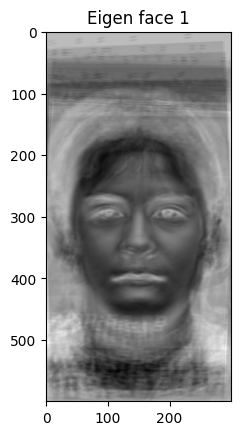

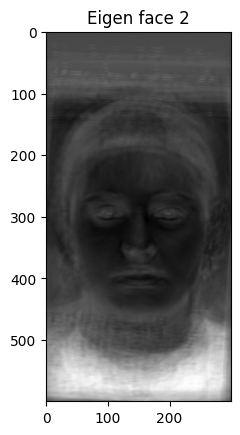

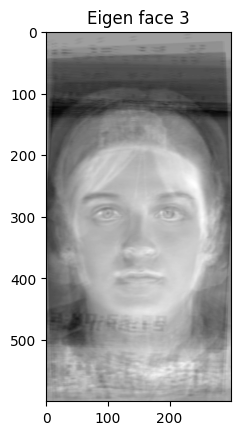

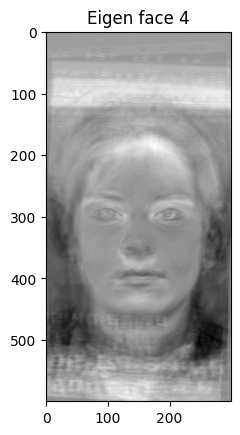

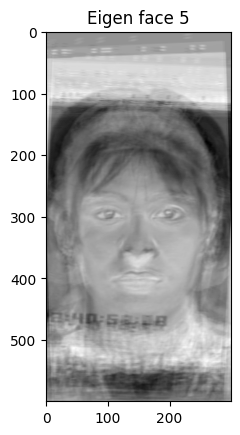

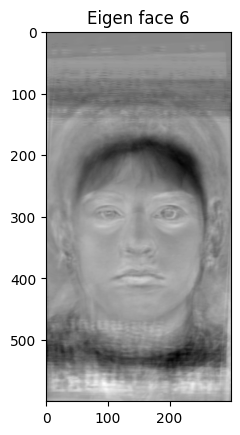

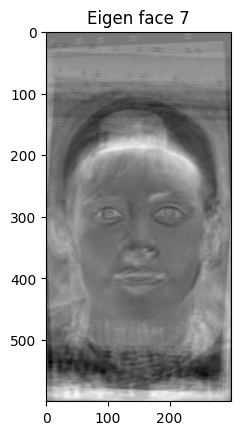

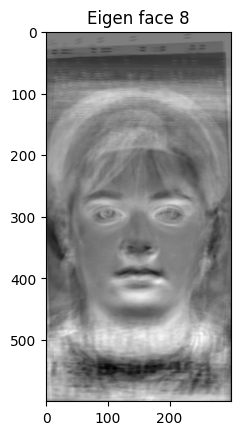

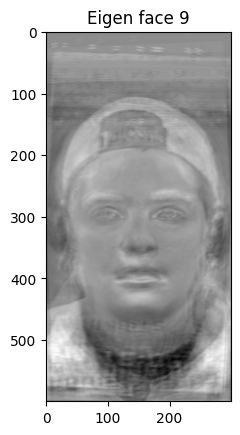

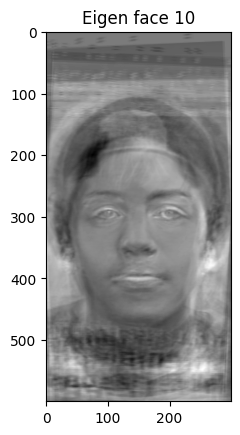

In [141]:
# Eigen faces
for i in range(10):
    u = U[:, i]
    eigen_face = u.reshape(N1, N2)
    plt.figure()
    plt.imshow(eigen_face, cmap='gray')
    plt.title(f'Eigen face {i+1}')

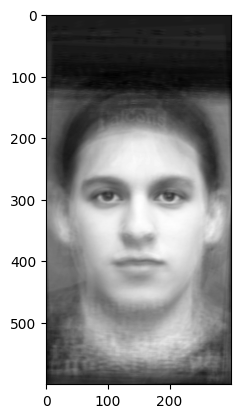

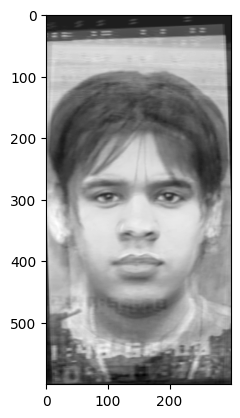

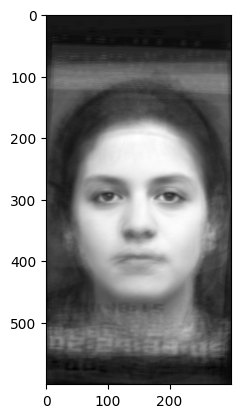

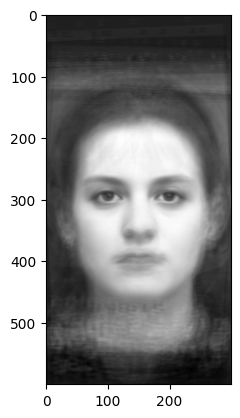

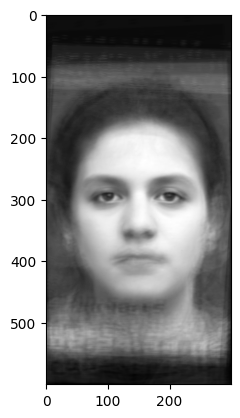

In [153]:
# Reconstruct images from eigen faces
N_eigen = 10
U_truncated = U[:, :N_eigen]
reconstructed_faces = U_truncated @ (U_truncated.T @ A)
num_test = len(train_flattened)

for i in range(5):
    idx = random.choice(range(num_test))
    rc_face = reconstructed_faces[:, [idx]] + m
    rc_face = rc_face.reshape(N1, N2)
    plt.figure()
    plt.imshow(rc_face, cmap='gray')

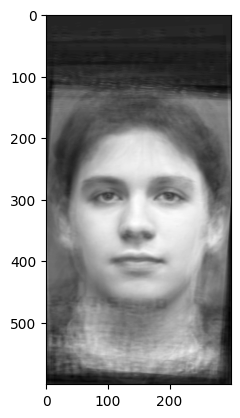

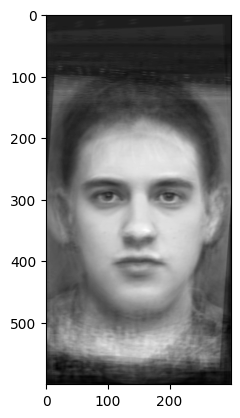

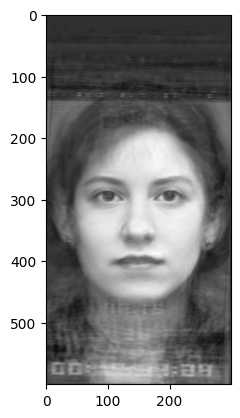

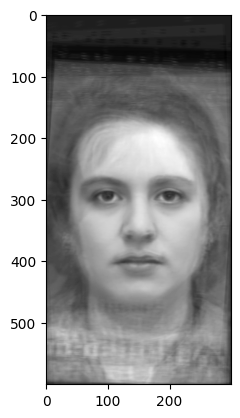

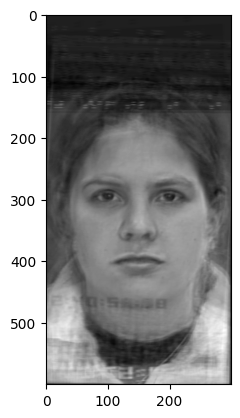

In [285]:
# Reconstruct images from eigen faces
N_eigen = 20
U_truncated = U[:, :N_eigen]
reconstructed_faces = U_truncated @ (U_truncated.T @ A)
num_test = len(train_flattened)

for i in range(5):
    idx = random.choice(range(num_test))
    rc_face = reconstructed_faces[:, [idx]] + m
    rc_face = rc_face.reshape(N1, N2)
    plt.figure()
    plt.imshow(rc_face, cmap='gray')

The more eigen values we use to reconstruct the images, the clearer the images will be.

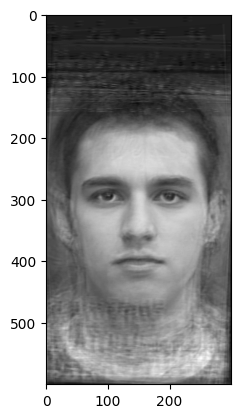

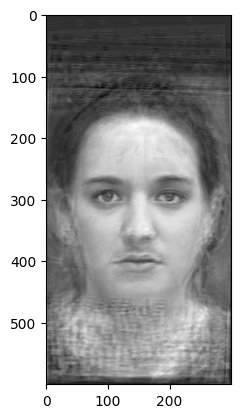

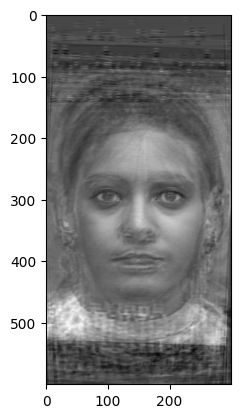

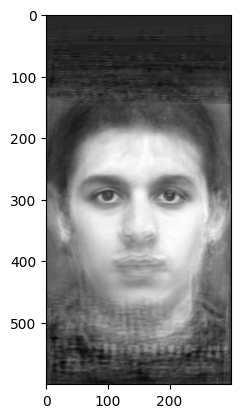

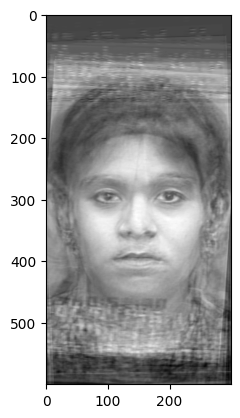

In [293]:
# Eigen faces for test data
B = np.concatenate(test_flattened, axis=1)
B = B - m
N_eigen = A.shape[1]
U_truncated = U[:, :N_eigen]
reconstructed_faces = U_truncated @ (U_truncated.T @ B)
num_test = len(test_flattened)

for i in range(5):
    idx = random.choice(range(num_test))
    rc_face = reconstructed_faces[:, [idx]] + m
    rc_face = rc_face.reshape(N1, N2)
    plt.figure()
    plt.imshow(rc_face, cmap='gray')

Despite using all of the eigen vectors to reconstruct test images, they are still noisy.

## Part 3 - Sentiment subspaces

In [236]:
# Read images

def load_images(image_dir='', mask=None):
    
    train_imgs = list()
    
    train_files = os.listdir(image_dir)
    
    for file in train_files:
        img = cv2.imread(str(image_dir / file))
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if mask is not None:
            img_gray = cv2.bitwise_and(img_gray, img_gray, mask=mask)
            
        train_imgs.append(img_gray)

    return train_imgs

MASK = np.ones((N1, N2), dtype=np.uint8) * 255
MASK[:200, :] = 0
MASK[-150:, :] = 0
MASK[:, :50] = 0
MASK[:, -50:] = 0

# Surprise
IMAGE_DIR = Path('dataset/surprise/')
train_imgs_surprise = load_images(IMAGE_DIR, mask=MASK)

# Disgust
IMAGE_DIR = Path('dataset/disgust/')
train_imgs_disgust = load_images(IMAGE_DIR, mask=MASK)

# Happy
IMAGE_DIR = Path('dataset/happy/')
train_imgs_happy = load_images(IMAGE_DIR, mask=MASK)

N1, N2  = train_imgs_happy[0].shape

In [240]:
# Flatten images
train_flattened_surprise = [
    img.reshape(-1, 1) for img in train_imgs_surprise
]

train_flattened_disgust = [
    img.reshape(-1, 1) for img in train_imgs_disgust
]

train_flattened_happy = [
    img.reshape(-1, 1) for img in train_imgs_happy
]

In [244]:
# Get eigen values

U_surprise, m_surprise = get_eigen_values(train_flattened_surprise)
U_disgust, m_disgust = get_eigen_values(train_flattened_disgust)
U_happy, m_happy = get_eigen_values(train_flattened_happy)

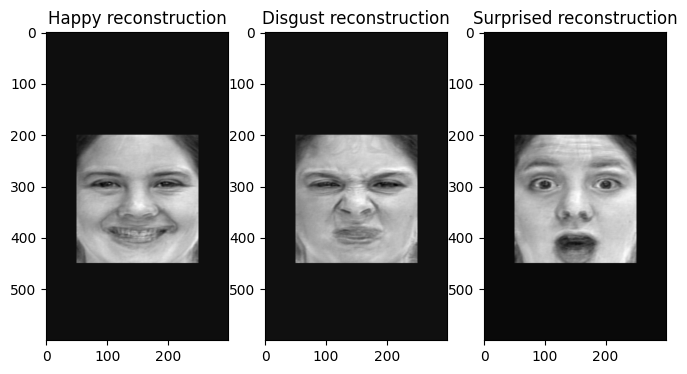

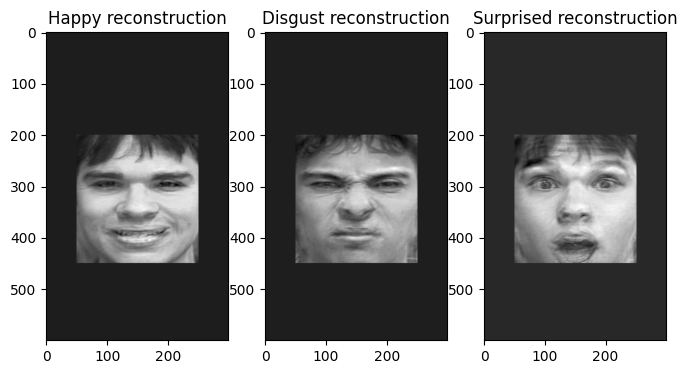

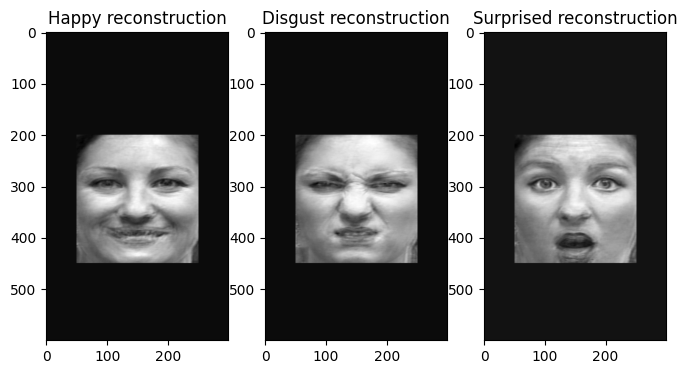

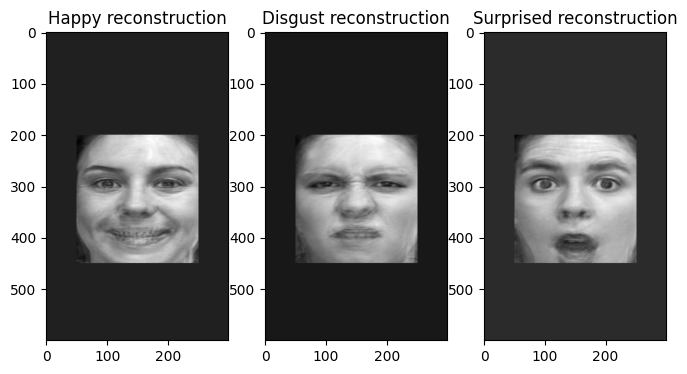

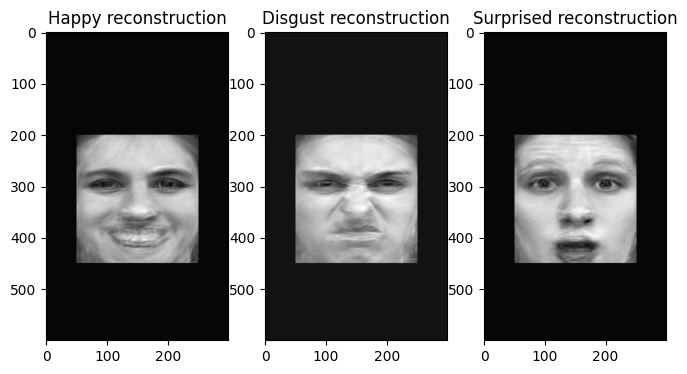

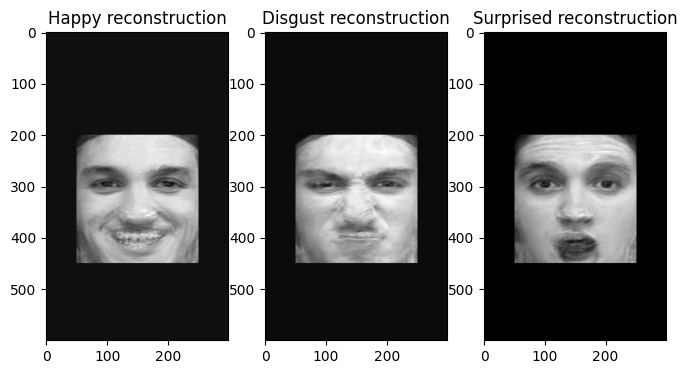

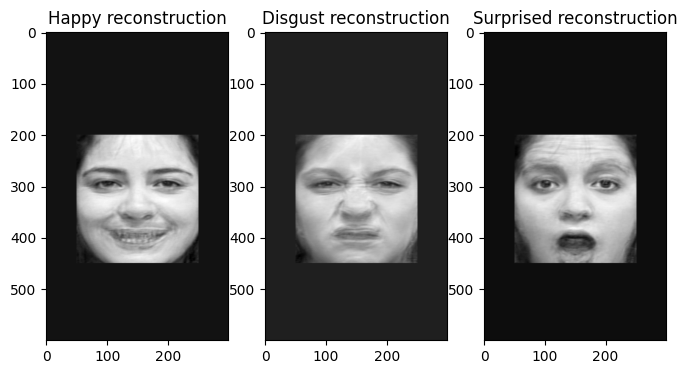

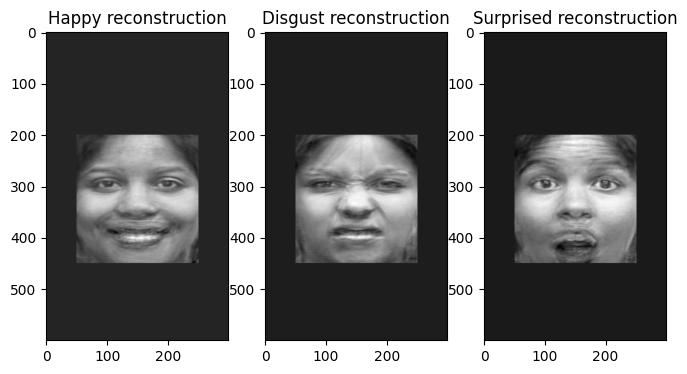

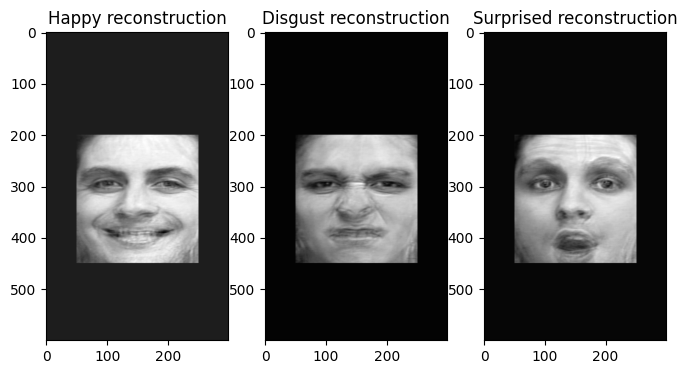

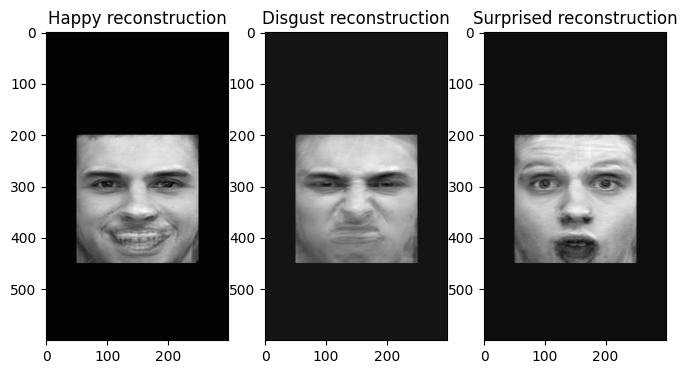

In [263]:
# Reconstruct faces

for i in range(10):
    idx = random.choice(range(len(train_imgs)))
    img = A[:, [idx]]
    fig = plt.figure(figsize=(8, 4))
    
    # Happy reconstruction
    happy_reconstructed = U_happy @ (U_happy.T @ img) + m_happy
    happy_reconstructed = happy_reconstructed.reshape(N1, N2)
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(happy_reconstructed, cmap='gray', aspect='auto')
    ax1.set_title('Happy reconstruction')

    # Disgust reconstruction
    disgust_reconstructed = U_disgust @ (U_disgust.T @ img) + m_disgust
    disgust_reconstructed = disgust_reconstructed.reshape(N1, N2)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(disgust_reconstructed, cmap='gray', aspect='auto')
    ax2.set_title('Disgust reconstruction')

    # Surprised reconstruction
    surprised_reconstructed = U_surprise @ (U_surprise.T @ img) + m_surprise
    surprised_reconstructed = surprised_reconstructed.reshape(N1, N2)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(surprised_reconstructed, cmap='gray', aspect='auto')
    ax3.set_title('Surprised reconstruction')

1. Unfortunately, individuals' identities are not preserved in the reconstruction process.
2. The feelings are changed.
3. Eyes and eyebrows are reconstructed better than other parts of the face.